In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
import random
%matplotlib inline

In [2]:
# matplotlib settings
settings = {'text.usetex': True,
        'font.weight' : 'normal',
        'font.size'   : 20}

plt.rcParams.update(**settings)

dpi = 300

In [3]:
fuel_to_color = {
    "biomass": "forestgreen",
    "hard coal": "dimgray",
    "hydro": "mediumblue",
    "lignite": "saddlebrown",
    "gas": "dodgerblue",
    "uran": "darkorange",
    "oil": "darkviolet",
    "waste": "lightseagreen",
    "wind": "cyan",
    "sun": "gold"
}

period_to_file_extension = {
    "winter": "1_winter_",
    "summer": "2_summer_"
}

model_type_to_description = {
    "dispatch_nuclear": "Dispatch with nuclear plants",
    "dispatch": "Dispatch without nuclear plants",
    "dc_load_flow_nuclear": "DC load flow with nuclear plants",
    "dc_load_flow": "DC load flow without nuclear plants"
}

time_periods = ["winter", "summer"]

In [4]:
def plot_energybalance_single(model_type, time_period):
    path = "export_files/" + model_type + "/"

    generation_by_fuel = pd.read_csv(path + period_to_file_extension[time_period] + "generation_by_fuel.csv")
    consumption = pd.read_csv(path + period_to_file_extension[time_period] + "consumption.csv")
    price = pd.read_csv(path + period_to_file_extension[time_period] + "price.csv")



    t = generation_by_fuel.timestep.values

    # production
    production_stacked = np.vstack([list(generation_by_fuel[fuel]) 
                   for fuel in list(generation_by_fuel) 
                   if fuel != "timestep"]
                 )

    # consumption
    consumption_stacked = np.vstack([list(consumption[i]) 
                   for i in list(consumption) 
                   if i != "timestep"]
                 )

    # demand 
    demand = -consumption.demand.values
    
    #price 
    price_values = price.price.values


    labels = [fuel for fuel in list(generation_by_fuel)
                 if fuel != "timestep"
             ]

    colors = [fuel_to_color[fuel] for fuel in list(generation_by_fuel)
                 if fuel != "timestep"
             ]

    fig, ax = plt.subplots(figsize=(12,8))
    ax.stackplot(t, production_stacked, labels=labels, colors=colors)
    ax.stackplot(t, consumption_stacked, 
                 labels=["demand", "curtailment"], 
                 colors=["slategray", "red"])
    ax.plot(t, demand, linestyle="--", color="slategray")
    plt.hlines(0, xmin=1, xmax=len(t),linestyles="-", linewidth=2.0)
    ax.legend(loc="lower right")
    ax.set_xlabel("Hourly timesteps")
    ax.set_ylabel("MW")
    ax.set_title(model_type_to_description[model_type] + " - " + time_period)
    ax.grid()
    
    # price axis
    ax2 = ax.twinx()
    ax2.plot(t, price_values, label="market price", color="k", linestyle="-")
    ax2.set_ylabel("Price in " + r'$\frac{Euro}{MWh}$')
    ax2.legend()
    
    plt.show()
    
def plot_energybalance_grid_all(model_type):
    
    if model_type == "dispatch":
        models = ["dispatch_nuclear", "dispatch"]
    elif model_type == "dc_load_flow":
        models = ["dc_load_flow_nuclear", "dc_load_flow"]
    else:
        print("Please choose between 'dispatch' and 'dc_load_flow'.")
        return
    
    fig, ax = plt.subplots(2,2,figsize=(26,16))
    
    for col, model in enumerate(models):
        for row, time_period in enumerate(time_periods):
            
            path = "export_files/" + model + "/"

            generation_by_fuel = pd.read_csv(path + period_to_file_extension[time_period] + "generation_by_fuel.csv")
            consumption = pd.read_csv(path + period_to_file_extension[time_period] + "consumption.csv")
            price = pd.read_csv(path + period_to_file_extension[time_period] + "price.csv")
            
            t = generation_by_fuel.timestep.values

            # production
            production_stacked = np.vstack([list(generation_by_fuel[fuel]) 
                           for fuel in list(generation_by_fuel) 
                           if fuel != "timestep"]
                         )

            # consumption
            consumption_stacked = np.vstack([list(consumption[i]) 
                           for i in list(consumption) 
                           if i != "timestep"]
                         )

            # demand 
            demand = -consumption.demand.values
            
            # price
            price_values = price.price.values
            

            labels = [fuel for fuel in list(generation_by_fuel)
                         if fuel != "timestep"
                     ]

            colors = [fuel_to_color[fuel] for fuel in list(generation_by_fuel)
                         if fuel != "timestep"
                     ]

            ax[row][col].stackplot(t, production_stacked, labels=labels, colors=colors)
            ax[row][col].stackplot(t, consumption_stacked, 
                         labels=["demand", "curtailment"], 
                         colors=["slategray", "red"])
            ax[row][col].plot(t, demand, linestyle="--", color="slategray")
            ax[row][col].axhline(y=0, xmin=0, xmax=1, linewidth=2.0, linestyle = "-", color="k")
            ax[row][col].set_title(model_type_to_description[model] + " - " + time_period)
            ax[row][col].grid()
            
            # price axis - only for dispatch
            if model == "dispatch" or model == "dispatch_nuclear":
                ax2 = ax[row][col].twinx()
                l1 = ax2.plot(t, price_values, label="market price", color="k", linestyle="-")
                if col == 1:
                    ax2.set_ylabel("Price in " + r'$\frac{Euro}{MWh}$')
                #ax2.legend(loc="upper left")
    
    ax[1][0].set_xlabel("Hourly timesteps")
    ax[1][1].set_xlabel("Hourly timesteps")
    ax[0][0].set_ylabel("MW")
    ax[1][0].set_ylabel("MW")
            
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels_2 = [sum(lol, []) for lol in zip(*lines_labels)]
    if model == "dispatch":
        fig.legend(lines, labels, loc = "center left")
        fig.legend(handles= [Line2D([0], [0], color = "k", label = "market price")], loc="center right")
    else:
        fig.legend(lines, labels, loc = "center left")
            
    plt.savefig("figures/energy_balance_" + model_type + ".png", dpi=dpi, bbox_inches="tight")
    plt.show()

In [5]:
def plot_distribution_generation_grid_all(model_type):
    
    if model_type == "dispatch":
        models = ["dispatch_nuclear", "dispatch"]
    elif model_type == "dc_load_flow":
        models = ["dc_load_flow_nuclear", "dc_load_flow"]
    else:
        print("Please choose between 'dispatch' and 'dc_load_flow'.")
        return
    
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    
    for col, model in enumerate(models):
        for row, time_period in enumerate(time_periods):
            
            path = "export_files/" + model + "/"

            generation_by_fuel = pd.read_csv(path + period_to_file_extension[time_period] + "generation_by_fuel.csv")
            consumption = pd.read_csv(path + period_to_file_extension[time_period] + "consumption.csv")
            
            demand_sum = -consumption.demand.sum()
            curtailment_sum = -consumption.curtailment.sum()
            generation_sum = 0
            
            fuel_to_sum_generation = {}
            for column in generation_by_fuel.columns:
                if column != "timestep":
                    generation_sum += generation_by_fuel[column].sum()
                    fuel_to_sum_generation[column] = generation_by_fuel[column].sum()

            sizes = [value for key, value in fuel_to_sum_generation.items() 
                     if value/generation_sum > 0.005]

            labels = [key + " (" + str(int(round(value/generation_sum*100))) + " \%)"
                      for key, value in fuel_to_sum_generation.items() 
                      if value/generation_sum > 0.005]

            colors = [fuel_to_color[key] for key, value in fuel_to_sum_generation.items() 
                      if value/generation_sum > 0.005]

            ax[row][col].pie(sizes, 
                             colors=colors, 
                             labels=labels, 
                             startangle=210)
            ax[row][col].set_title(model_type_to_description[model] + " - " + time_period, pad=2)
            ax[row][col].axis("equal")
    plt.tight_layout()
    plt.savefig("figures/generation_distribution_" + model_type + ".png", dpi=dpi, bbox_inches="tight")
    plt.show()

# Dispatch

## Energy Balance

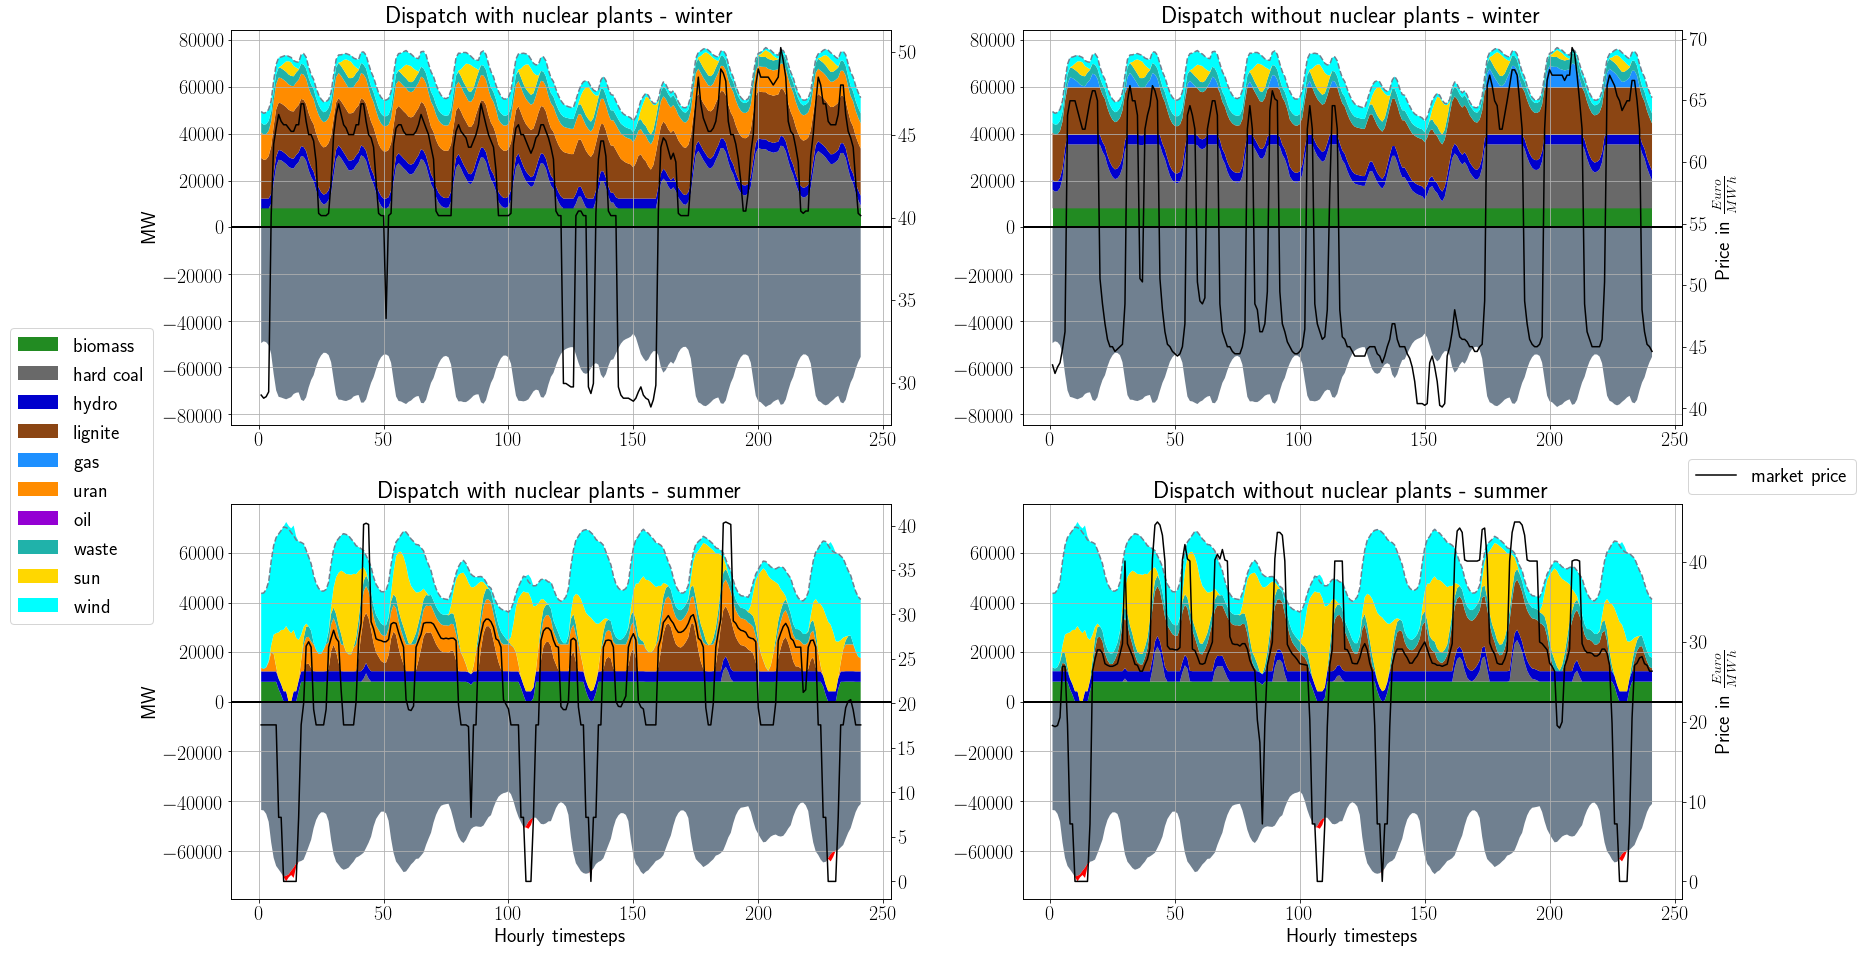

In [6]:
plot_energybalance_grid_all("dispatch")

## Distribution of generation

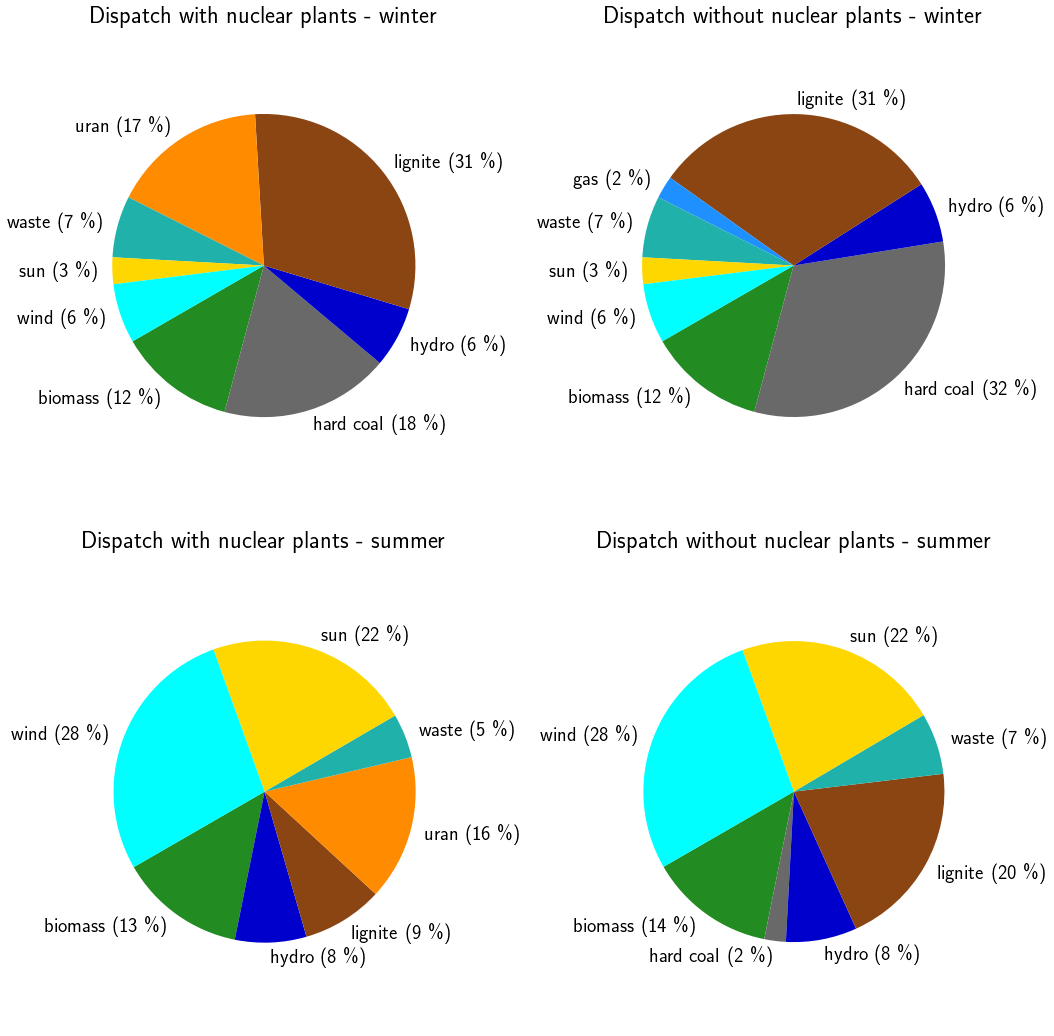

In [7]:
plot_distribution_generation_grid_all("dispatch")

# DC Load Flow

## Energy Balance

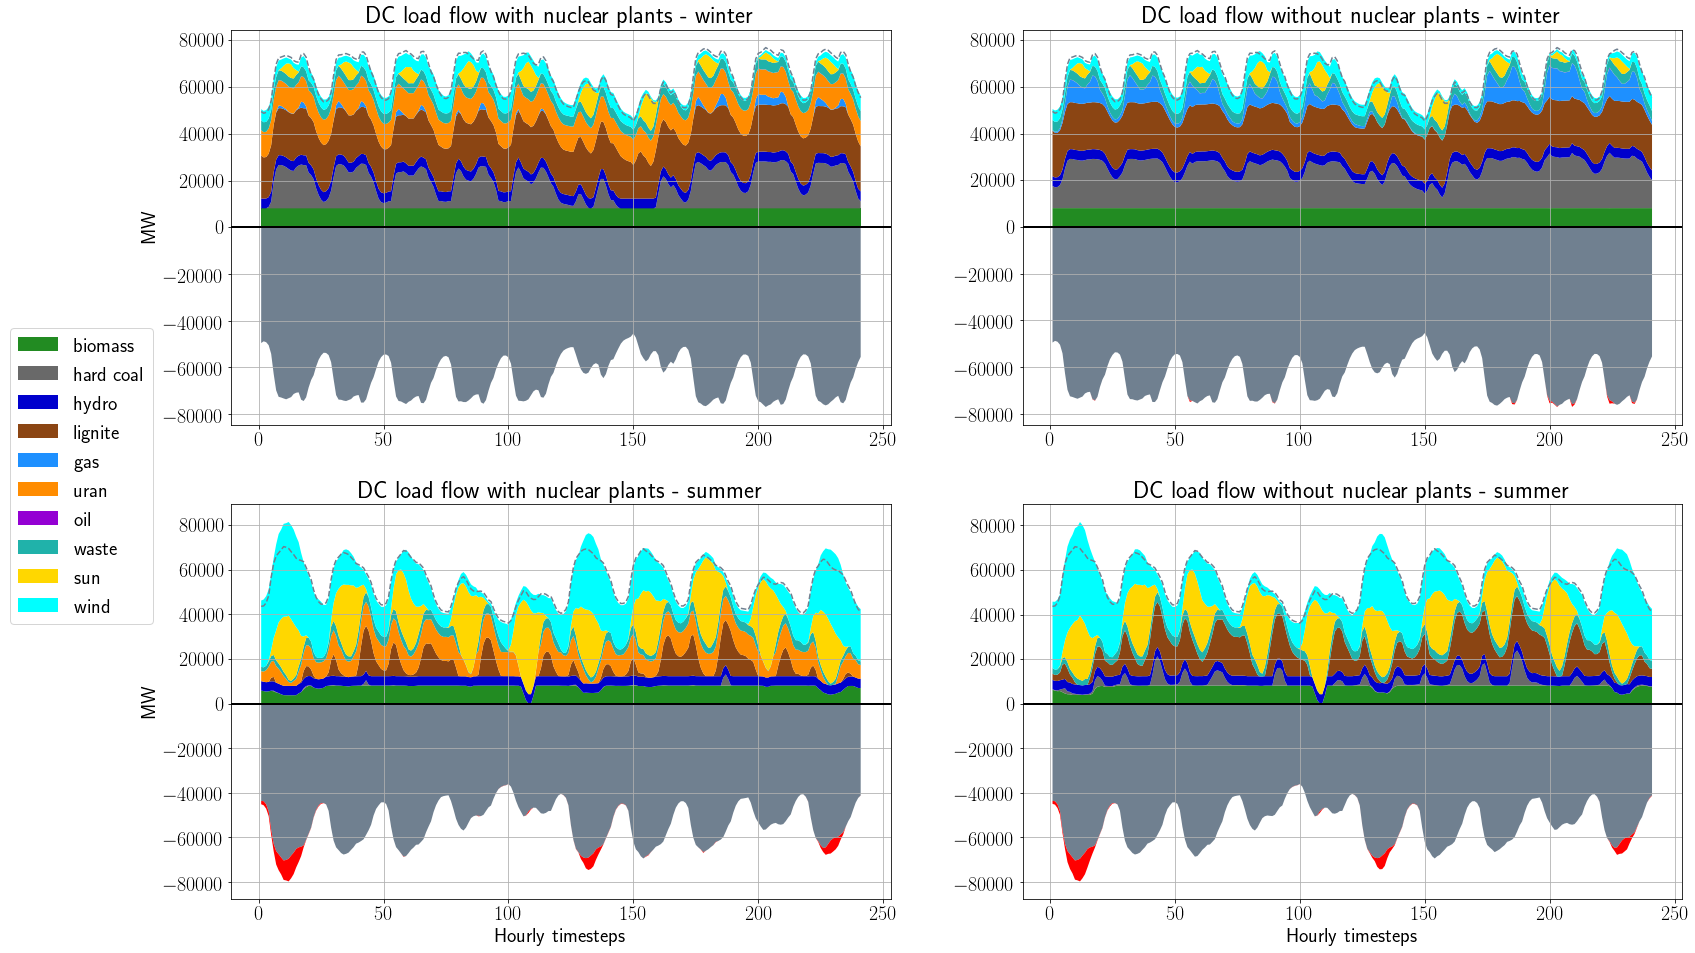

In [8]:
plot_energybalance_grid_all("dc_load_flow")

## Distribution of generation

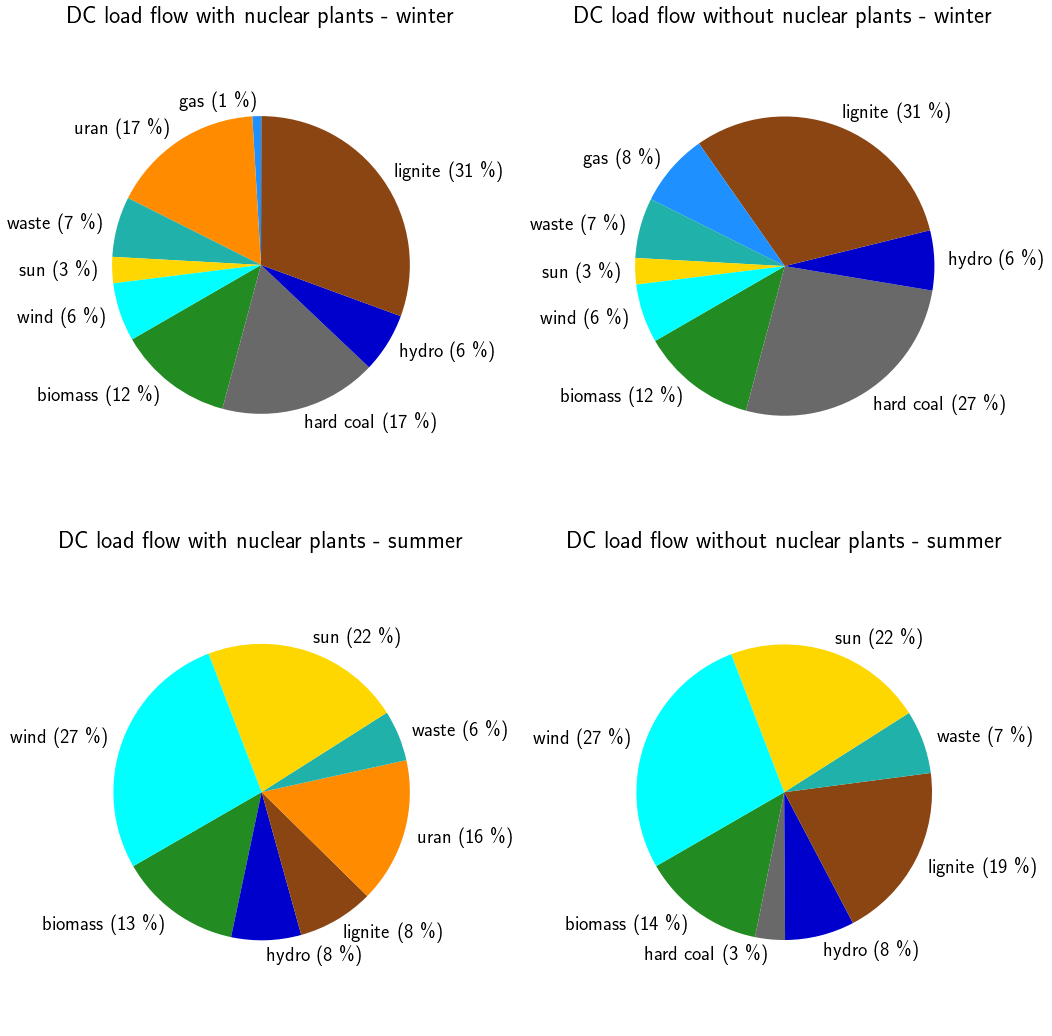

In [9]:
plot_distribution_generation_grid_all("dc_load_flow")

## Price

## Price difference 

In [10]:
price_nuclear = pd.read_csv("export_files/dc_load_flow_nuclear/1_winter_price.csv")
price_no_nuclear = pd.read_csv("export_files/dc_load_flow/1_winter_price.csv")

In [11]:
nodes = price_nuclear.node.unique()
length = len(price_nuclear)

In [12]:
price_merged = price_nuclear.merge(right=price_no_nuclear, how="inner", on=["node", "timestep"])
price_merged.rename(columns = {"price_x":"price_nuclear", "price_y":"price_no_nuclear"}, inplace=True)
price_merged["difference"] = price_merged.price_no_nuclear - price_merged.price_nuclear
price_merged

,timestep,node,price_nuclear,price_no_nuclear,difference
0,1,n3303,46.439381,68.813160,22.373779
1,2,n3303,46.439381,68.813160,22.373779
2,3,n3303,46.439381,68.813160,22.373779
3,4,n3303,46.439381,68.813160,22.373779
4,5,n3303,46.439381,68.813160,22.373779
...,...,...,...,...,...
140980,237,n8066,44.377724,58.666416,14.288691
140981,238,n8066,43.329185,48.606456,5.277271
140982,239,n8066,40.063941,43.244193,3.180252
140983,240,n8066,37.153992,34.366403,-2.787589


In [13]:
nodes = price_merged.node.unique()
node_differences = pd.DataFrame(
    zip([node for node in nodes],
        [price_merged[price_merged.node == node].difference.mean() for node in nodes], 
        [price_merged[price_merged.node == node].difference.median() for node in nodes],
       ),
    columns = ["node", "mean_value", "median_value"]
)

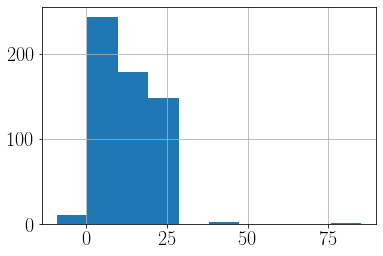

In [14]:
node_differences.median_value.hist()

In [15]:
# matplotlib settings
settings = {'text.usetex': True,
        'font.weight' : 'normal',
        'font.size'   : 14}

plt.rcParams.update(**settings)

dpi = 300

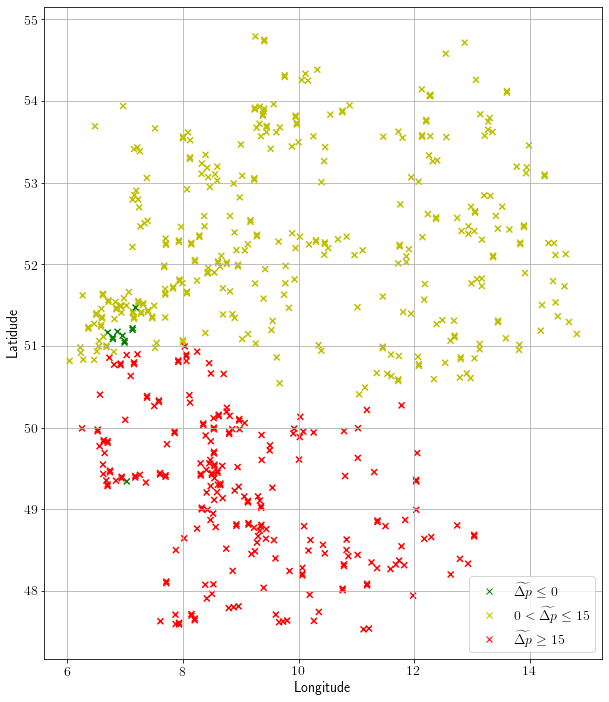

In [16]:
data_model_nodes = pd.read_csv("data/winter/nodes.csv")
    
node_to_geo = {}
for index, row in data_model_nodes.iterrows():
    node_to_geo[row["index"]] = {"lon": row.lon, "lat": row.lat}
node_to_geo

color = []

for node in nodes:
    price_node = node_differences[node_differences.node == node].median_value.values[0]
    if price_node <= 0:
        color.append("g")
    elif price_node <= 15 and price_node > 0 :
        color.append("y")
    elif price_node > 15:
        color.append("r")
    
nodes_lon = data_model_nodes.lon
nodes_lat = data_model_nodes.lat

fig, ax = plt.subplots(figsize=(10,12))
ax.scatter(x=nodes_lon, y=nodes_lat, color=color, marker="x")

legend_elements = [Line2D([0],[0],
                        color = "g",
                        label = r'$\widetilde{\Delta p}\leq0$',
                        linestyle = "None",
                        marker = "x"),
                   Line2D([0],[0],
                        color = "y",
                        label = r'$0<\widetilde{\Delta p}\leq15$',
                        linestyle = "None",
                        marker = "x"),
                   Line2D([0],[0],
                        color = "r",
                        label = r'$\widetilde{\Delta p}\geq15$',
                        linestyle = "None",
                        marker = "x"),
                  ]

plt.xlabel("Longitude")
plt.ylabel("Latidude")
plt.grid()
ax.legend(handles=legend_elements, 
          loc="lower right")
plt.savefig("figures/price_difference_nodal_phase_out.png", dpi=dpi, bbox_inches="tight")
plt.show()

## Price median

In [17]:
price_nuclear = pd.read_csv("export_files/dc_load_flow_nuclear/2_summer_price.csv")
nodes = price_nuclear.node.unique()
node_prices = pd.DataFrame(
    zip([node for node in nodes],
        [price_nuclear[price_nuclear.node == node].price.mean() for node in nodes], 
        [price_nuclear[price_nuclear.node == node].price.median() for node in nodes],
       ),
    columns = ["node", "mean_value", "median_value"]
)

In [18]:
node_prices.describe()

,mean_value,median_value
count,585.000000,585.000000
mean,22.327861,23.100289
std,2.290776,2.786549
min,16.177627,17.590909
25%,20.404963,20.217147
50%,22.825127,23.496928
75%,24.203669,25.749205
max,32.817055,28.394066


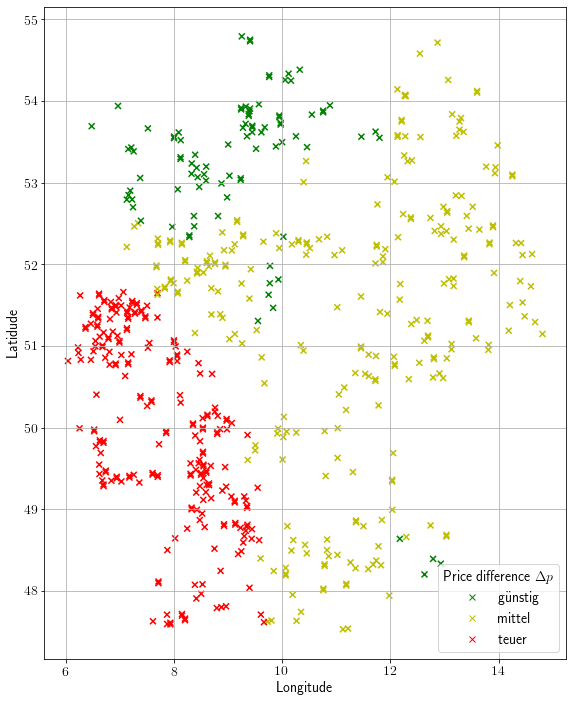

In [19]:
data_model_nodes = pd.read_csv("data/winter/nodes.csv")
    
node_to_geo = {}
for index, row in data_model_nodes.iterrows():
    node_to_geo[row["index"]] = {"lon": row.lon, "lat": row.lat}
node_to_geo

color = []

for node in nodes:
    price_node = node_prices[node_prices.node == node].median_value.values[0]
    if price_node <= 20:
        color.append("g")
    elif price_node <= 25 and price_node > 20 :
        color.append("y")
    elif price_node > 25:
        color.append("r")
    
nodes_lon = data_model_nodes.lon
nodes_lat = data_model_nodes.lat

fig, ax = plt.subplots(figsize=(10,12))
ax.scatter(x=nodes_lon, y=nodes_lat, color=color, marker="x")

legend_elements = [Line2D([0],[0],
                        color = "g",
                        label = "günstig",
                        linestyle = "None",
                        marker = "x"),
                   Line2D([0],[0],
                        color = "y",
                        label = "mittel",
                        linestyle = "None",
                        marker = "x"),
                   Line2D([0],[0],
                        color = "r",
                        label = "teuer",
                        linestyle = "None",
                        marker = "x"),
                  ]

plt.xlabel("Longitude")
plt.ylabel("Latidude")
plt.grid()
ax.legend(handles=legend_elements, loc="lower right", title="Price difference $\Delta p$")
plt.subplots_adjust(right=0.85)
#plt.savefig("figures/overview_lines_nodes.png", dpi=dpi)
plt.show()

# Anything else

# Nodes + lines graph

In [20]:
# matplotlib settings
settings = {'text.usetex': True,
        'font.weight' : 'normal',
        'font.size'   : 14}

plt.rcParams.update(**settings)

dpi = 300

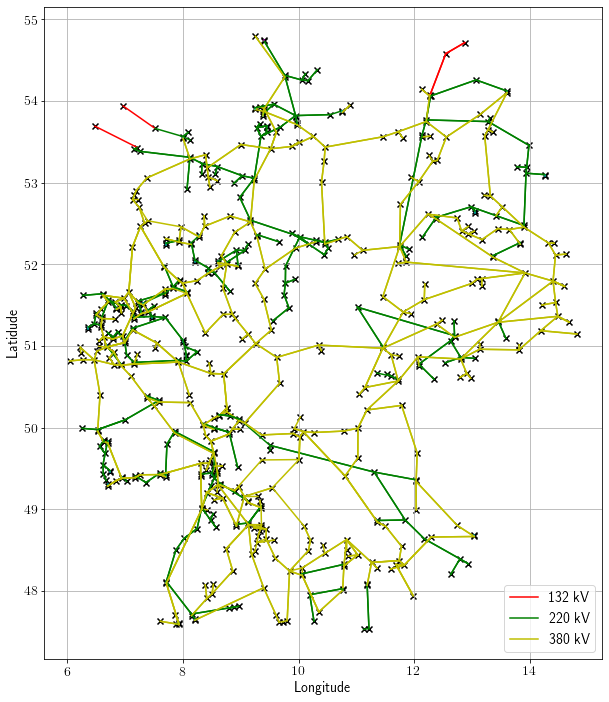

In [21]:
data_model_nodes = pd.read_csv("data/winter/nodes.csv")
data_model_lines = pd.read_csv("data/winter/lines.csv")

colors =["r", "g", "y", "c", "m", "orange", "dimgrey", "fuchsia"]
color_count = 0
line_types = data_model_lines.type.unique()
line_type_to_color = {}
for line_type in line_types:
    line_type_to_color[line_type] = colors[color_count]
    color_count += 1
    
node_to_geo = {}
for index, row in data_model_nodes.iterrows():
    node_to_geo[row["index"]] = {"lon": row.lon, "lat": row.lat}
node_to_geo
    
nodes_lon = data_model_nodes.lon
nodes_lat = data_model_nodes.lat

fig, ax = plt.subplots(figsize=(10,12))
ax.scatter(x=nodes_lon, y=nodes_lat, color="k", marker="x")
#for index, row in data_test_nodes.iterrows():
#    plt.annotate(row["index"], 
#                    xy=(node_to_geo[row["index"]]["lon"],
#                        node_to_geo[row["index"]]["lat"]),
#                    xycoords='data',
#                    xytext=(0,+2),
#                    textcoords='offset points')
legend_elements = [Line2D([0], [0],
                        color = line_type_to_color[line_type],
                        label = line_type + " kV") 
                   for line_type in line_types
                   if line_type != "220.0/380.0" and line_type != "132.0/380.0" 
                       and line_type != "132.0/220.0"
                  ]
for index, row in data_model_lines.iterrows():
    ax.plot([node_to_geo[row.node_i]["lon"],node_to_geo[row.node_j]["lon"]],
             [node_to_geo[row.node_i]["lat"],node_to_geo[row.node_j]["lat"]],
             color = line_type_to_color[row.type]
            )
ax.legend(handles=legend_elements, loc="lower right")
plt.xlabel("Longitude")
plt.ylabel("Latidude")
plt.grid()
plt.savefig("figures/overview_lines_nodes.png", dpi=dpi, bbox_inches="tight")
plt.show()

## Availability

In [22]:
data_timeseries = pd.read_csv("data/timeseries.csv")

In [23]:
data_timeseries

,index,zone,wind onshore,wind offshore,solar,utc_timestamp
0,t0001,DE,0.339069,0.707495,0.0,2017-01-01 00:00:00
1,t0002,DE,0.331253,0.706424,0.0,2017-01-01 01:00:00
2,t0003,DE,0.321440,0.706638,0.0,2017-01-01 02:00:00
3,t0004,DE,0.325235,0.706424,0.0,2017-01-01 03:00:00
4,t0005,DE,0.336398,0.704497,0.0,2017-01-01 04:00:00
...,...,...,...,...,...,...
8731,t8732,DE,0.974076,0.746253,0.0,2017-12-30 19:00:00
8732,t8733,DE,0.977843,0.708565,0.0,2017-12-30 20:00:00
8733,t8734,DE,0.919556,0.757602,0.0,2017-12-30 21:00:00
8734,t8735,DE,0.869422,0.754604,0.0,2017-12-30 22:00:00


In [40]:
    # time period
    t_start = time_dic["summer"] - 1
    t_end = t_start + days*24 +  1

    index_start = data_timeseries[(data_timeseries.index == t_start)].index.values[0]
    index_end = data_timeseries[(data_timeseries.index == t_end)].index.values[0]
    data_timeseries.loc[index_end]

index                          t4010
zone                              DE
wind onshore                0.435259
wind offshore               0.581799
solar                              0
utc_timestamp    2017-06-17 01:00:00
Name: 4009, dtype: object

In [24]:
# matplotlib settings
settings = {'text.usetex': True,
        'font.weight' : 'normal',
        'font.size'   : 20}

plt.rcParams.update(**settings)

dpi = 300

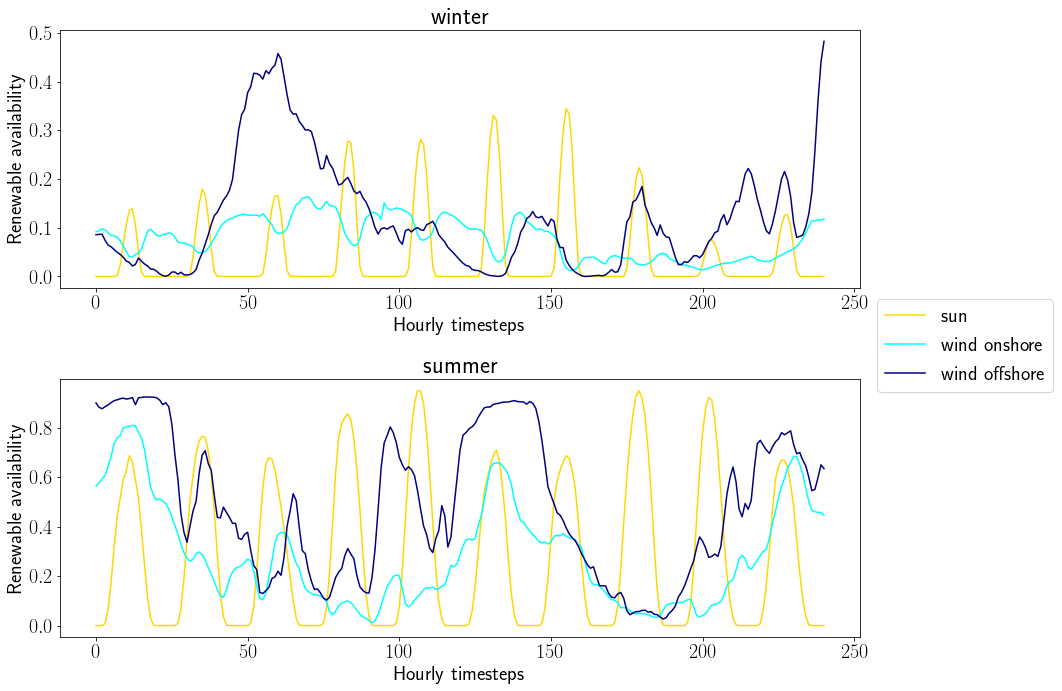

In [25]:
# time dictionary
time_dic = {"winter": 361,
            "summer": 3769
            }
days = 10

times = ["winter", "summer"]

fig, ax = plt.subplots(2,1, figsize=(15,10))

for row, time in enumerate(times):

    # time period
    t_start = time_dic[time] - 1
    t_end = t_start + days*24 +  1

    index_start = data_timeseries[(data_timeseries.index == t_start)].index.values[0]
    index_end = data_timeseries[(data_timeseries.index == t_end)].index.values[0]
    index_solar = data_timeseries.columns.get_loc("solar")
    index_windonshore = data_timeseries.columns.get_loc("wind onshore")
    index_windoffshore = data_timeseries.columns.get_loc("wind offshore")
    solar = data_timeseries.iloc[index_start:index_end, index_solar]
    windonshore = data_timeseries.iloc[index_start:index_end, index_windonshore]
    windoffshore = data_timeseries.iloc[index_start:index_end, index_windoffshore]
    t = [*range(0,len(solar))]


    ax[row].plot(t, solar, label="sun", color="gold")
    ax[row].plot(t, windonshore, label="wind onshore", color="cyan")
    ax[row].plot(t, windoffshore, label="wind offshore", color="navy")
    ax[row].set_xlabel("Hourly timesteps")
    ax[row].set_ylabel("Renewable availability")
    ax[row].set_title(time)

legend_elements = [Line2D([0],[0],
                    color = "gold",
                    label = "sun"),
                   Line2D([0],[0],
                    color = "cyan",
                    label = "wind onshore"),
                   Line2D([0],[0],
                    color = "navy",
                    label = "wind offshore")]
    
fig.legend(handles=legend_elements, loc="center right")

plt.tight_layout()
plt.subplots_adjust(right=0.81)
plt.savefig("figures/availability.png", dpi=dpi, bbox_inches="tight")
plt.show()

## Generation mix

In [26]:
data_plants = pd.read_csv("data/winter/plants.csv")

In [33]:
data_plants

,Unnamed: 0,index,node,mc_el,mc_heat,g_max,h_max,eta,tech,fuel,plant_type,lat,lon,heatarea,name,city,company,commissioned,status,storage_capacity
0,0,p0,n4763,17.883756,0.0,16.800,0.0,0.4026,steam,biomass,conventional,51.984761,9.822831,NaN,Werkskraftwerk Sappi Alfeld,Alfeld,Sappi Alfeld GmbH,1988.0,operating,NaN
1,1,p1,n8046,17.548136,0.0,9.800,0.0,0.4103,steam,biomass,conventional,47.797140,10.858740,NaN,HKW Altenstadt,Altenstadt,Heizkraftwerk Altenstadt GmbH & Co. KG,1999.0,operating,NaN
2,2,p2,n5556,17.399710,0.0,138.900,600.0,0.4138,steam,biomass,conventional,52.727130,12.011150,NaN,Zellstoff Stendal GmbH,Arneburg,Zellstoff Stendal GmbH,2004.0,operating,NaN
3,3,p3,n7261,17.370326,0.0,1.100,0.0,0.4145,steam,biomass,conventional,49.988218,9.155761,NaN,Blockheizkraftwerk 1,Aschaffenburg,DS Smith Paper Deutschland GmbH,2005.0,operating,NaN
4,4,p4,n7261,17.224880,0.0,0.800,0.0,0.4180,steam,biomass,conventional,49.988218,9.155761,NaN,Blockheizkraftwerk 2,Aschaffenburg,DS Smith Paper Deutschland GmbH,2010.0,operating,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,3451,p3553,n8047,0.000000,0.0,40.450,0.0,1.0000,wind onshore,wind,wind onshore,50.771208,6.811523,NaN,NaN,NaN,NaN,NaN,operating,NaN
3120,3452,p3554,n8051,0.000000,0.0,13.875,0.0,1.0000,wind onshore,wind,wind onshore,53.182173,8.419647,NaN,NaN,NaN,NaN,NaN,operating,NaN
3121,3453,p3555,n8055,0.000000,0.0,4.000,0.0,1.0000,wind onshore,wind,wind onshore,51.955268,8.437500,NaN,NaN,NaN,NaN,NaN,operating,NaN
3122,3454,p3556,n8060,0.000000,0.0,202.865,0.0,1.0000,wind onshore,wind,wind onshore,53.196984,8.595428,NaN,NaN,NaN,NaN,NaN,operating,NaN


In [28]:
fuel_types = data_plants.fuel.unique()
fuel_type_to_generation = {fuel_type:0 for fuel_type in fuel_types}
generation_sum_capacity = 0

for index, row in data_plants.iterrows():
    generation_sum_capacity += row.g_max
    fuel_type_to_generation[row.fuel] += row.g_max

In [29]:
sizes = [value for key, value in fuel_type_to_generation.items()]

labels = [key + " (" + str(int(round(value/generation_sum_capacity*100))) + " \%)"
          for key, value in fuel_type_to_generation.items()]

colors = [fuel_to_color[key] for key, value in fuel_type_to_generation.items()]

In [30]:
# matplotlib settings
settings = {'text.usetex': True,
        'font.weight' : 'normal',
        'font.size'   : 20}

plt.rcParams.update(**settings)

dpi = 300

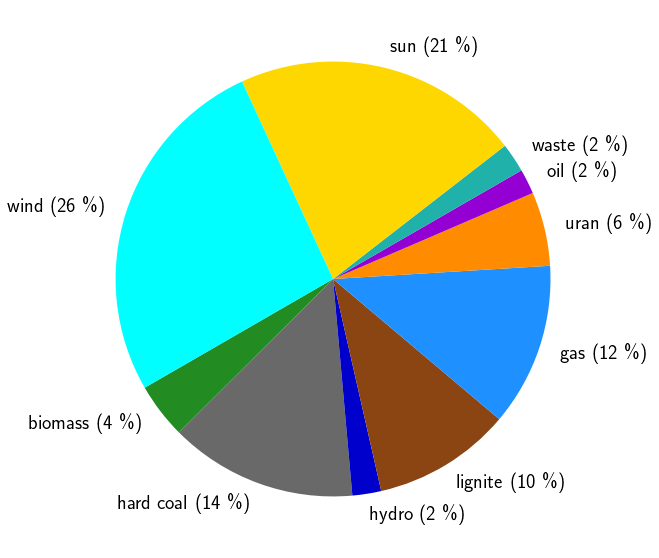

In [31]:
plt.figure(figsize=(10,10))

plt.pie(sizes, 
         colors=colors, 
         labels=labels, 
         startangle=210)
plt.savefig("figures/generation_mix.png", dpi=dpi, bbox_inches="tight")
plt.show()